In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  accuracy_score

In [29]:
#  ファイルの読み込み]
DATA_HOME_DIR = "./raw/"
train = pd.read_csv(DATA_HOME_DIR + 'train.csv')
test = pd.read_csv(DATA_HOME_DIR + 'test.csv')
gender_submission = pd.read_csv(DATA_HOME_DIR + 'gender_submission.csv')

前処理

In [31]:
# 前処理のためにtrainとtestを連結
train['is_test'] = 0
train['is_train'] = 1
test['is_test'] = 1 
test['is_train'] = 0

# 目的変数
Y = train['Survived']
train_X = train.drop(['Survived'], axis = 1)

# テストID
test_id = test['PassengerId']
test_X = test

# 連結
all_df = pd.concat([train_X, test_X], axis=0)

In [32]:
all_df.drop(['Name', 'Cabin', 'Ticket'],  axis=1,  inplace=True)

In [33]:
# カテゴリ変数を取得する関数
def _get_categorical_features(df):
    feats = [col for col in list(df.columns) if df[col].dtype == 'object']
    return feats

# カテゴリ変数をファクトライズ (整数に置換)する関数
def _factorize_categoricals(df, cats):
    for col in cats:
        df[col], _ = pd.factorize(df[col])
    return df 

# カテゴリ変数のダミー変数 (二値変数化)を作成する関数
def _get_dummies(df, cats):
    for col in cats:
        df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    return df 

In [34]:
# カテゴリ変数を取得
all_df_cats = _get_categorical_features(all_df)
all_df_cats

['Sex', 'Embarked']

In [35]:
# ダミー変数を取得
all_df = _get_dummies(all_df, all_df_cats)
all_df.drop(all_df_cats,  axis=1,  inplace=True)
all_df.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,is_test,is_train,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,1,3,22.0,1,0,7.2500,0,1,0,1,0,0,1
1,2,1,38.0,1,0,71.2833,0,1,1,0,1,0,0
2,3,3,26.0,0,0,7.9250,0,1,1,0,0,0,1
3,4,1,35.0,1,0,53.1000,0,1,1,0,0,0,1
4,5,3,35.0,0,0,8.0500,0,1,0,1,0,0,1


In [36]:
# 最終的なtrainとtestデータを用意
ignore_features = ['PassengerId', 'is_train', 'is_test']
relevant_features = [col for col in all_df.columns if col not in ignore_features]
trainX = all_df[all_df['is_train'] == 1][relevant_features]
testX = all_df[all_df['is_test'] == 1][relevant_features]

In [37]:
from sklearn.model_selection import train_test_split 
x_train, x_val, y_train, y_val = train_test_split(trainX, Y, test_size=0.3, random_state=18)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [38]:
from sklearn.model_selection import KFold

#  3分割交差検証を指定し、インスタンス化
kf  =  KFold(n_splits=3)
params  =  {
    'objective':  'binary',
    'learning_rate':  0.1,
    'num_leaves'  :  300
}

# kf.split(X_train.Ytrain)で、X_trainとY_trainを3分割し、交差検証をする
for  train_index,  test_index  in kf.split(trainX, Y):
    X_cv_train  = trainX.iloc[train_index]
    X_cv_test  = trainX.iloc[test_index]
    Y_cv_train  =  Y[train_index]
    Y_cv_test  =  Y[test_index]

    #  識別機を作成
    gbm  =  lgb.LGBMClassifier(objective='binary',
        num_leaves  =  300,
        learning_rate  =  0.1,
        )

    #  学習
    gbm.fit(X_cv_train, Y_cv_train,
    eval_set  =  [(X_cv_test,  Y_cv_test)],
    early_stopping_rounds=10,)

    #  予測し精度を表示
    Y_pred  = gbm.predict(X_cv_test,num_iteration=gbm.best_iteration_)
    print(round(accuracy_score(Y_cv_test,Y_pred)*100,2))

[1]	valid_0's binary_logloss: 0.620239
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.593798
[3]	valid_0's binary_logloss: 0.572528
[4]	valid_0's binary_logloss: 0.554015
[5]	valid_0's binary_logloss: 0.539266
[6]	valid_0's binary_logloss: 0.527844
[7]	valid_0's binary_logloss: 0.518635
[8]	valid_0's binary_logloss: 0.510455
[9]	valid_0's binary_logloss: 0.504106
[10]	valid_0's binary_logloss: 0.498639
[11]	valid_0's binary_logloss: 0.493381
[12]	valid_0's binary_logloss: 0.490238
[13]	valid_0's binary_logloss: 0.486524
[14]	valid_0's binary_logloss: 0.484927
[15]	valid_0's binary_logloss: 0.482375
[16]	valid_0's binary_logloss: 0.481922
[17]	valid_0's binary_logloss: 0.480232
[18]	valid_0's binary_logloss: 0.475995
[19]	valid_0's binary_logloss: 0.47274
[20]	valid_0's binary_logloss: 0.469822
[21]	valid_0's binary_logloss: 0.468911
[22]	valid_0's binary_logloss: 0.469166
[23]	valid_0's binary_logloss: 0.469686
[24]	valid_0's binary_loglos

C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


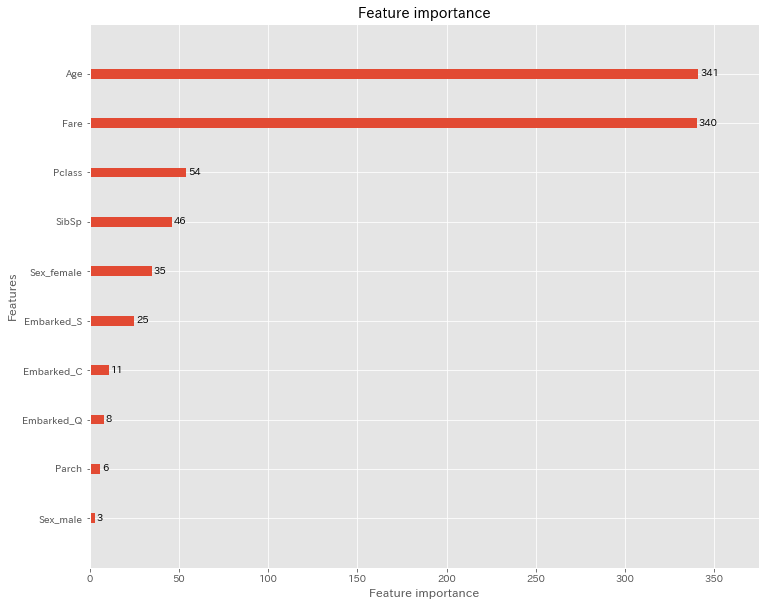

In [39]:
lgb.plot_importance(gbm, figsize=(12, 10));

In [41]:
gbm.fit(trainX, Y)
# 予測
pred = gbm.predict(testX)
# 提出用
gender_submission["Survived"] = pred
gender_submission.to_csv('./submit/submit_lgbm01.csv',index=None)

C:\Users\naofumi_honda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
